In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 60
pd.options.display.max_rows = 500
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import datetime as dt

## Canasta basica regional a precios constantes

### Indice de precios

In [2]:
## Correr la notebook 00 - deflator index

In [3]:
# # col_mon = [u'P21', u'P47T', u'PP08D1', u'TOT_P12', u'T_VI', u'V12_M', u'V2_M', u'V3_M', u'V5_M']

# cpi = pd.read_csv('./../data/info/indice_precios_M.csv', index_col=0)
# cpi.index = pd.to_datetime(cpi.index)
# cpi = cpi.loc['2000':]

# cpi.columns = pd.MultiIndex.from_product([['Indice de Precios'], cpi.columns])


### Valores de las canastas regionales, basica y total

In [4]:
timeindex = pd.date_range(start = dt.datetime(2016,4,1), end = dt.datetime(2019,6,30), freq='MS')
timeindex = timeindex #- pd.to_timedelta(timeindex.day - 15, unit='d') #- pd.DateOffset(months=1)


CBAr = pd.read_csv('./../data/info/CBA_regional.csv')
CBAr.index = timeindex
CBAr = CBAr.drop(['Ano4', 'Mes', 'TRIMESTRE'], axis = 1)

CBTr = pd.read_csv('./../data/info/CBT_regional.csv')
CBTr.index = timeindex
CBTr = CBTr.drop(['Ano4', 'Mes', 'TRIMESTRE'], axis = 1)

#.stack().reset_index()
CB = pd.concat([CBAr.stack(), CBTr.stack()], axis = 1)
CB.columns = ['CBA', 'CBT']; CB.index.names = ['Mes', 'Region']

In [5]:
# # 11747 (oct-nov 2019) se tiene que convertir en 
# 11747*(2283/1906) #para junio 2019
# # 11747*(1.231485) #para 2019Q2

In [7]:
cpi_M = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_M.csv', index_col=0)
# cpi_M = pd.read_csv('./../data/info/indice_precios_M.csv', index_col=0)
# cpi_M = pd.read_csv('./../../encuestador-de-hogares/data/info/indice_precios_M.csv', index_col=0)
cpi_M.index = pd.to_datetime(cpi_M.index)

## OPCION INDICE SE FIJA X MES
cpi_2016 = cpi_M.loc['2016-01'] ## OJO porque los modelos vienen entrenados con sueldos de esa nominalidad.
# O sea, la fecha de escala nominal de aca (canasta) tiene que ser la misma que la de los modelos (EPH training).

cpi_M_CB = cpi_M.loc[CB.unstack().index]
# cpi_M_CB = cpi_M.loc['2003':]
cpi_M_CB.columns = pd.MultiIndex.from_product([['Indice de Precios'], cpi_M_CB.columns])
# cpi_M_CB
# cpi_M_CB.columns = pd.MultiIndex([('A', 'B')])
# cpi_M_CB
# display(cpi_M.tail(10))
# cpi_mes_actual = cpi_M.iloc[-1][0]

In [8]:
# cpi_mes_actual

In [9]:
## Fijarse que los archivos actualizados pueden estar en la carpeta del encuestador de hogares.
# cpi_d = pd.read_csv('./../data/info/indice_precios_d.csv', index_col=0)
cpi_d = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_d.csv', index_col=0)

# cpi_d = pd.read_csv('./../../encuestador-de-hogares/data/info/indice_precios_d.csv', index_col=0)
display(cpi_d.tail())

## OPCION INDICE SE FIJA X DIA
# cpi_2016 = cpi_d.loc['2016-01-01']
# cpi_2016

,log_index,index
d,,
2022-05-28,0.965827,911.319722
2022-05-29,0.966276,912.192978
2022-05-30,0.966724,913.065713
2022-05-31,0.967171,913.937926
2022-06-01,0.967617,914.809617


### Deflacta Canasta

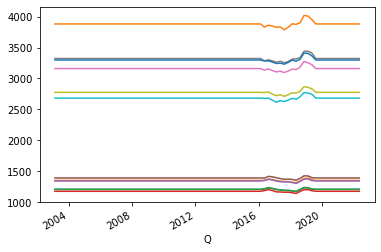

In [23]:
CB_i = pd.concat([CB.unstack(), cpi_M_CB], axis = 1)
# CB_i
# CB_defl = CB_i.iloc[:, :-1].div(CB_i[('Indice de Precios', 'index')], 0)*cpi_2016['index'] # # divided by cpi index, multiplicado por nivel 2016
# CB_defl = CB_i.iloc[:, :-1].div(CB_i[('Indice de Precios', 'index')], 0)*cpi_2016['index'].values[0]
CB_defl = CB_i.drop('Indice de Precios', axis = 1).div(CB_i[('Indice de Precios', 'index')], 0)*cpi_2016['index'].values[0]
CB_defl = CB_defl.reindex(cpi_M.loc['2003':].index)

# # # Check how the fillna works...
# fig, ax = plt.subplots(1, figsize = (7, 5))
# CB_defl.fillna(CB_defl.mean()).plot(legend = False, ax = ax)
# # # CB_defl.fillna(CB_defl.quantile(.25)).head(25).plot(legend = False, ax = ax, c = '.5')
# # # CB_defl.fillna(CB_defl.quantile(.75)).head(25).plot(legend = False, ax = ax, c = '.5')

CB_defl = CB_defl.fillna(CB_defl.mean()).stack()

# CB_defl
CB_defl_Q = CB_defl.groupby([pd.Grouper(level = 0,freq = 'Q'), pd.Grouper(level = 1)]).mean()
CB_defl_Q.index.names = ['Q', 'Region']

CB_defl_Q = CB_defl_Q.unstack()
CB_defl_Q.index = CB_defl_Q.index - pd.to_timedelta(CB_defl_Q.index.day - 15, unit='d') - pd.DateOffset(months=1)

CB_defl_Q.plot(legend = False)

CB_defl_Q = CB_defl_Q.stack().reset_index()
CB_defl_Q.to_csv('./../data/info/CB_Reg_defl.csv', index = False)
# # precios de 2016-1-1

### Chequear valores de la canasta en 2010

In [25]:
ix = pd.read_csv('./../data/info/indice_precios_M.csv', index_col = 0)
ix.index = pd.to_datetime(ix.index)
ix_2010 = ix.loc['2010-11-15'].values[0]
ix_2016 = ix.loc['2016-01-15'].values[0]
ipc_10_16 = (ix_2016/ix_2010)

In [30]:
show = CB_defl_Q.loc[CB_defl_Q.Q == '2010-11-15'].set_index(['Q', 'Region'])/ipc_10_16
show = show.round().astype(int)
show

CBA   CBT
Q          Region                      
2010-11-15 Cuyo               328   861
           Gran Buenos Aires  367   905
           Noreste            328   756
           Noroeste           319   730
           Pampeana           365   899
           Patagónica         378  1058

In [26]:
# cpi_Q = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_Q.csv', index_col=0)

# # cpi_d = pd.read_csv('./../../encuestador-de-hogares/data/info/indice_precios_d.csv', index_col=0)
# # display(cpi_Q.tail())
# cpi_Q/cpi_2016

## Deflactar PPP

In [ ]:
usd = pd.read_csv('./../data/info/ARS_USD_Q.csv')
ppp = pd.read_csv('./../data/info/ARG_PPP_Q.csv')
ppp = ppp.merge(usd)

ppp['ppp_5usd'] = 5.5*(ppp.Value/ppp.tipo_cambio_a3500)*365/12
ppp['ppp_5usd_ARS'] = 5.5*ppp.Value*365/12

ppp = ppp.merge(cpi_Q.reset_index())
ppp['index'] = ppp['index']/cpi_2016.values[0]
ppp['ppp_5usd_ARS_deflac'] = ppp['ppp_5usd_ARS']/ppp['index']

# ppp['Q'] = pd.to_datetime(ppp.Q)
ppp.tail()
# ppp.set_index('Q').groupby(pd.Grouper(level = 0, freq = 'Y')).mean().round(2)

# ppp.set_index('Q').ppp_5usd_ARS.plot(marker = '.')
# plt.yscale('log')

In [ ]:
ppp.to_csv('./../data/info/ppp_defl.csv', index = False)


## Listo

In [ ]:
# # Debug deflacion
# frac = 0.02
# val_list = []
# for q in ['2020-06-30', '2020-03-31']:
#     df = pd.read_csv('./../data/yr_samples/RFReg_'+str(frac)+'ARG'+q+'.csv', 
#                      usecols = ['P47T'], nrows = 50000)
#     val_list += [df.median().values[0]]
# plt.plot(np.array(val_list))

In [ ]:
CB_defl_Q.tail()